Most of the code in this notebook is from https://github.com/ageron/handson-ml. This is a great book - please buy the book to support the author.

This notebook can serve as a good training tutorial for beginner data scientists.

The 10-Step Machine Learning Project Workflow (My Version):
1. Define business object
2. Make sense of the data from a high level
    - data types (number, text, object, etc.)
    - continuous/discrete
    - basic stats (min, max, std, median, etc.) using boxplot
    - frequency via histogram
    - scales and distributions of different features
3. Create the traning and test sets using proper sampling methods, e.g., random vs. stratified
4. Correlation analysis (pair-wise and attribute combinations)
5. Data cleaning (missing data, outliers, data errors)
6. Data transformation via pipelines (categorical text to number using one hot encoding, feature scaling via normalization/standardization, feature combinations)
7. Train and cross validate different models and select the most promising one (Linear Regression, Decision Tree, and Random Forest were tried in this tutorial)
8. Fine tune the model using trying different combinations of hyperparameters
9. Evaluate the model with best estimators in the test set
10. Launch, monitor, and refresh the model and system

In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['housing.csv', '.DS_Store', 'anscombe.csv']


In [76]:
# loading data
data_path = "input/housing.csv"
housing = pd.read_csv(data_path)

# see the basic info
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


What information should we get from `info()`
- total observations: 20640: make sure you understand what is each observation. In this case, each observation is the data about a district
- total columns (features): 10
- data type of each feature: 9 numbers and 1 object (will handle later)
- meaning of each feature: it is very important to work with domain expert to fully understand each feature
- any null values (e.g., total_bedrooms is 20433, which indicates null values - will handle later)

In [78]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## Data Types
`head()` shows the valuse of top rows, which gives more idea on data types. Pandas guessed the data types of features when reading in the data, which may not always work. In this dataset, you can see ocean_proximity feature is text. Sometimes, the price feature may also be object type becaue the raw data has $ sign, in which case you need to convert the data type from object to float64 if you want to use this feature in the model.

## Basic Stats
`describe()` shows a summary of numerial features, which can be visualized using boxplots and histograms. `value_counts()` can be used to generate a summary of categorical features.

In [79]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


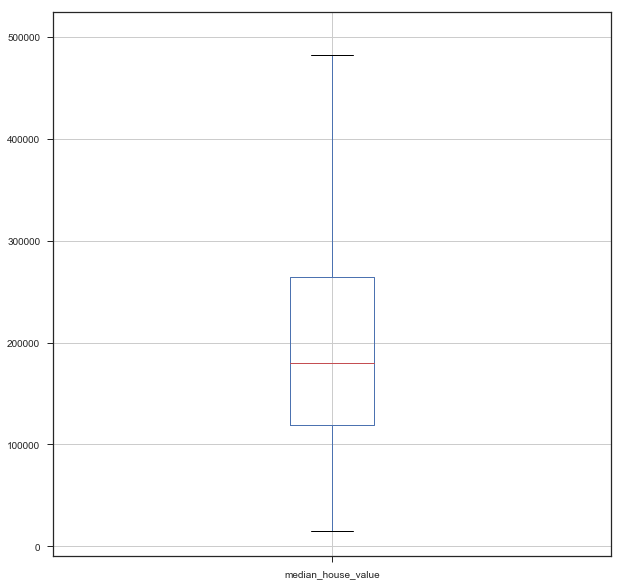

In [80]:
# boxplot 
housing.boxplot(['median_house_value'], figsize=(10, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117171fd0>,
      dtype=object)

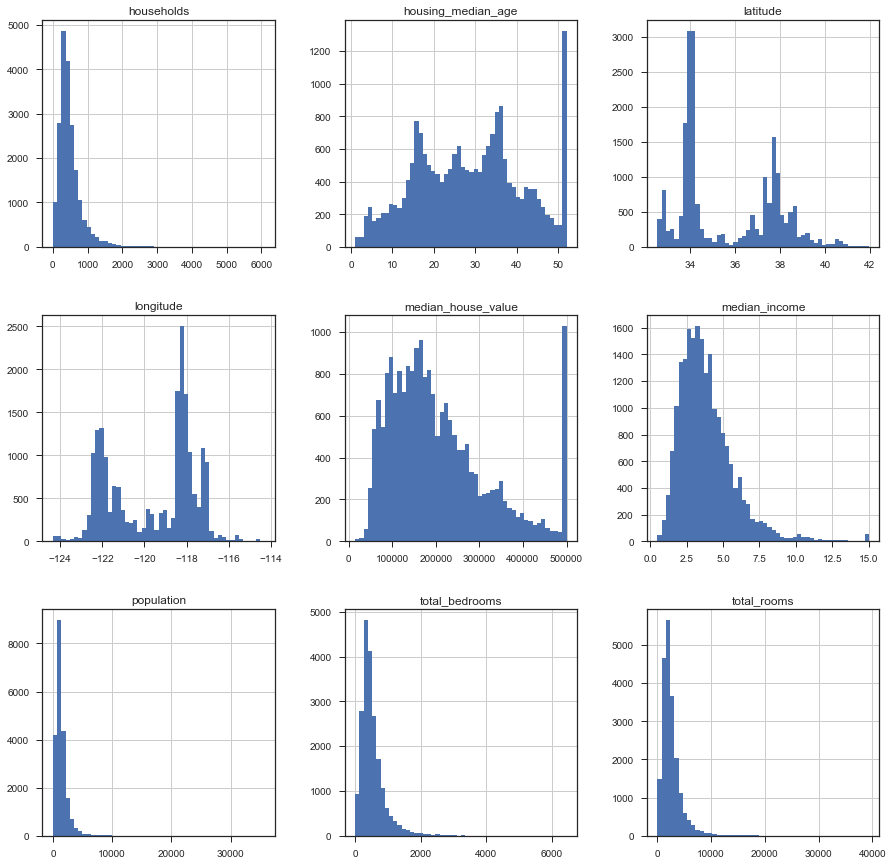

In [81]:
# histogram
housing.hist(bins=50, figsize=(15, 15))


Given that `.botplot()` and `.hist()` only handle numerical features. We cannot forget ocean_proximity, which is object type (no need to change to string).

In [82]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

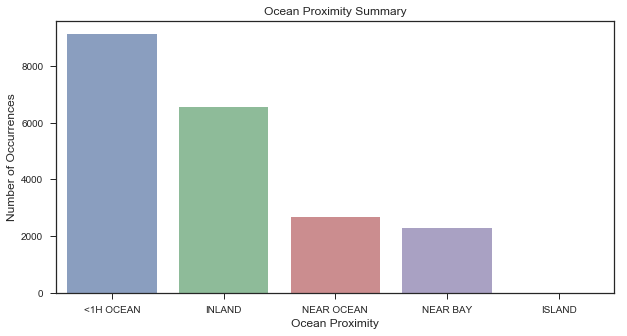

In [83]:
op_count = housing['ocean_proximity'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(op_count.index, op_count.values, alpha=0.7)
plt.title('Ocean Proximity Summary')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ocean Proximity', fontsize=12)
plt.show()
# housing['ocean_proximity'].value_counts().hist()

## Make Sence of the Data
What are the typical things we can learn from the basic statistics with visualizaitons? 
1. Do the data make sence? scan each column and see whether the data make sense at a high level. 
    - longitude, latitude and house median age seem to be OK. 
    - total rooms and total bedrooms are in hundreds and thousands - this does make sense given each row is a district
    - population seems to be OK but you want to know what's the unit for the number, e.g., thousands? millions? households are numbers of people living together, which is OK. Households mean is 499 and population mean is 1425, so you can tell that population is just the total number of people in each district not in thousands or millions. 
    - median income is apparently problematic - how can mean income be 3.87? Actually, this is because median income has been scaled and capped between 15.0001 (max) and  0.4999 (min). Preprocessed attributes like this are common. Knowning how the data is calculated is critical.
    - median house value data is OK and this is our target variable, i.e., we want to build a model to predict this value.
 
2. Feature scaling: you have noticed that the features have very different scales, which we need to handle later
3. Distribution: from the histograms, we can tell many of them are skewed, i.e., having a long tail on one side or the other. In many cases, we need to transform the data so that they have more bell-shaped distributions.

## Create Training, Validation, and Test Data Sets
To avoid [data snooping bias](https://en.wikipedia.org/wiki/Data_dredging), you should set aside 20% of the data as the test set without further exploriation of the data. 

In [84]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


In [85]:
# check whether the test set is the same for every run
test_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN
13311,-117.61,34.08,12.0,4427.0,NaN,2400.0,843.0,4.7147,158700.0,INLAND
7113,-118.02,33.89,36.0,1375.0,NaN,670.0,221.0,5.0839,198200.0,<1H OCEAN
7668,-118.08,33.92,38.0,1335.0,NaN,1011.0,269.0,3.6908,157500.0,<1H OCEAN
18246,-122.08,37.39,4.0,2292.0,NaN,1050.0,584.0,4.8036,340000.0,NEAR BAY
5723,-118.23,34.18,45.0,2332.0,NaN,943.0,339.0,8.1132,446600.0,<1H OCEAN


The above function will generate a different test set every time you run the program, which is undesirable. A few potential solutions:

1. save the test set and training set for the first run into csv files
2. set a fixed random number generator seed so that the random numbers are always the same (we use this approach in this notebook using `random_state=42`)

1 and 2 won't work if new data is loaded. The book proposed a method of hashing the identifier of the data to get the same test set (see page 50 for details). 


## About Sampling
In order to make sure that the test set is a good representation of the overall population. We may want to consider different sampling techniques:

- random sampling (what we used above): OK if the dataset is large enough (how large is enough?)
- stratified sampling: the population is devided into homogeneous subgroups called *strata* and the correct instances are sampled from each *stratum*  (such as for a survey of 1000 people, given US population has 51.3% female and 48.7% male, 513 female and 487 male should be surveyed instead of pure random sampling) 

Suppose you learned that median income is very important for predicting median housing prices. You may want to use stratified sampling for the test set. To do that, you first need to change median income from a continuse attribute to a categorical attribute. As shown in the histogram below, we can see most of the income are around 2 and 5, and some are beyond. 

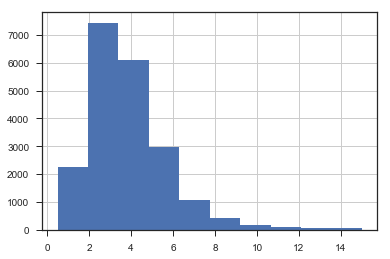

In [86]:
housing['median_income'].hist()

We limit the number of categories by dividing the median income by 1.5 and merge all the income greater than 5 into 5. Then, we can use stratified sampling.

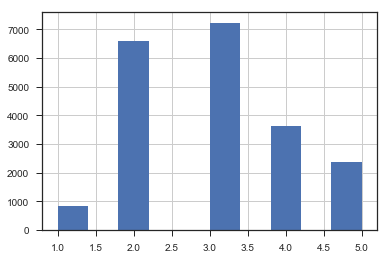

In [87]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
# DataFrame.where(cond, other=nan, inplace=False, axis=None, level=None, errors='raise', try_cast=False, raise_on_error=None)
# Where cond is True, keep the original value. Where False, replace with corresponding value from other
housing['income_cat'].where(housing['income_cat']<5, 5.0, inplace=True)
housing['income_cat'].hist()

In [88]:
# stratified sampling based on income categories
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5.0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4.0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3.0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3.0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3.0
20552,-121.80,38.68,11.0,3851.0,892.0,1847.0,747.0,3.4331,120600.0,INLAND,3.0
19989,-119.32,36.19,11.0,1281.0,291.0,861.0,313.0,1.0962,72300.0,INLAND,1.0
17049,-122.26,37.46,26.0,5067.0,750.0,1996.0,728.0,7.0001,500001.0,NEAR OCEAN,5.0
13692,-117.24,34.13,26.0,3774.0,716.0,1913.0,620.0,3.3534,98900.0,INLAND,3.0
13916,-116.15,34.14,18.0,3312.0,705.0,1251.0,512.0,3.0139,82600.0,INLAND,3.0


We can compare the different sampling results for the test set by comparing them to the overall population distribution as follows. As you can see, stratified sampling's distributions are much more similar to the overall distributions compared with random sampling

In [89]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [90]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [91]:
# we need to do the random sampling again to include income_cat column
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

test_set['income_cat'].value_counts() / len(test_set)

3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_cat, dtype: float64

In [92]:
# drop the income_cat attributes
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [93]:
# check the dropping result
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 10 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms        4079 non-null float64
population            4128 non-null float64
households            4128 non-null float64
median_income         4128 non-null float64
median_house_value    4128 non-null float64
ocean_proximity       4128 non-null object
dtypes: float64(9), object(1)
memory usage: 354.8+ KB


Now you should set aside the test set and only use the training set. When the training set is too large, you can also create an exploration set out of the training set to make the initial analysis fast. we create a copy of the training set as follows:

In [94]:
housing = strat_train_set.copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


### Additional Visualizations for Data Exploration
The following geographical data visualizations show that the price is related to the location and population density.

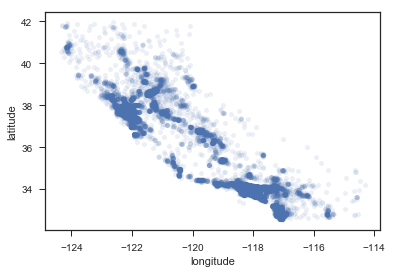

In [95]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

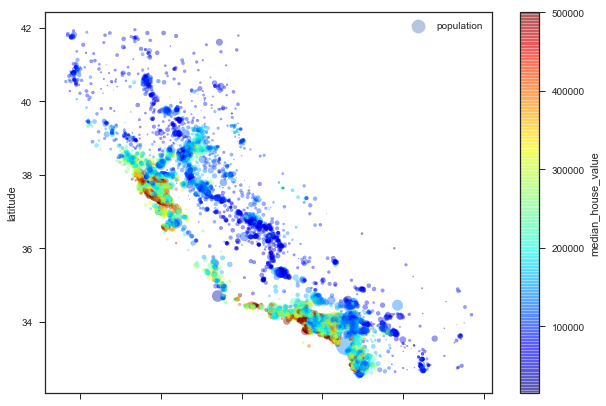

In [96]:
# option s: radius of each circle represent the population/100
# option c: color represents the median price
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=housing['population']/100, label='population', figsize=(10,7), 
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

### Correlation Analysis
We want to further explore the data to look for correlations between different attributes. correlation coefficient is between -1 and 1, representing negative and positive correlations. 0 means there is no liner correlation. Correlation is said to be linear if the **ratio of change** is constant, otherwise is non-linear. Visual inspection of data is very important, which cannot be replaced by simply looking at the correlation coefficients, i.e., check out Anscombe's quartet: https://en.wikipedia.org/wiki/Anscombe%27s_quartet

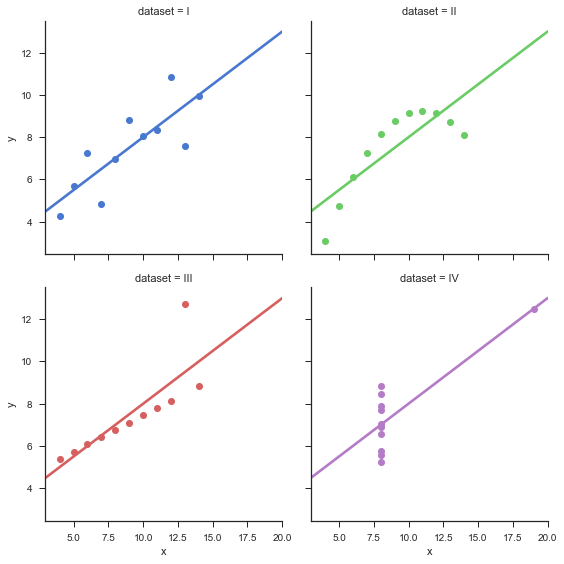

In [97]:
# Anscombe's quartet: https://seaborn.pydata.org/examples/anscombes_quartet.html
sns.set(style="ticks")
anscombe = pd.read_csv("input/anscombe.csv")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=anscombe,
           col_wrap=2, ci=None, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1})

In [98]:
# Pearson's r, aka, standard correlation coefficient for every pair
corr_matrix = housing.corr()
# Check the how much each attribute correlates with the median house value
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

/Users/harrywang/Documents/sandbox/data-analysis-tutorials/house-price-prediction/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12111f780>,
      dtype=object)

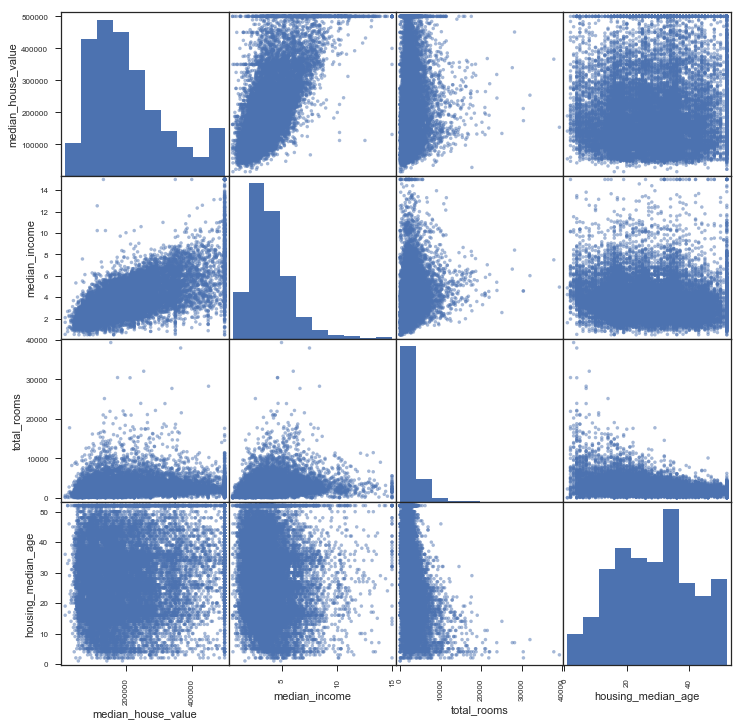

In [99]:
from pandas.tools.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,12))

We can see that median_income is a promising attribute to predict median_house_value. A close-up of the scatterplot is as follows:

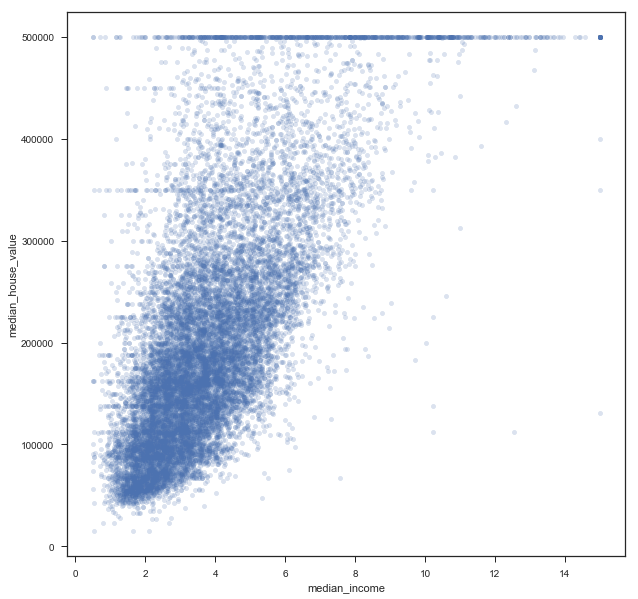

In [100]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.2, figsize=(10,10))

We can see there are a number of "horizontal lines" in the plot: one clear one at $500,000, one at $450,000, another one at $350,000, and a few other ones. Try to find out why that is happening. If you cannot figure out the reason, removing those data points (if not too many) might be a good idea before feeding the data to the algorithms. 

### Attribute Combinations
Sometime, the combinations of attributes are more meaningful and interesting in terms of solving the business problems, e.g.,
- rooms per household: total # of rooms per district is not useful but rooms per household may be interesting
- bedroom/total room ratio
- population per household

In [101]:
# calculated attributes
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

# checkout the correlations again
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Two findings after combining attributes:
1. rooms_per_household is slightly more correlated (0.146285) with house value than total_rooms (0.135097)
2. bedrooms_per_room is much more correlated (-0.259984) than total_rooms (0.135097) and total_bedrooms (0.047689): houses with lower bedroom/room ratio is more expensive: this sort of make sense, more expensive houses may have more offices, dens, playrooms, etc. 

### Data Cleaning and Transformation
Typically, data need to be cleaned and transformed before trying different ML algorithms.
#### missing data in one attribute. 
Three ways to handle this:
1.   remove the observations with missing values using `dropna()`; 
```
housing.dropna(subset=['total_bedrooms']
```
2.  remove the entire attribute using `drop()`;
```
housing.drop('total_bedrooms', axis=1)
```
3. set/impute the missing values using `fillna()`
```
median = housing['total_bedroom'].median()
housing['total_bedrooms'].fillna(median, inplace=True)
```

### Seperate the predictors (independent variables) and labels (target/dependent variables)
We want to create a clean training set first.

In [102]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 13 columns):
longitude                   16512 non-null float64
latitude                    16512 non-null float64
housing_median_age          16512 non-null float64
total_rooms                 16512 non-null float64
total_bedrooms              16354 non-null float64
population                  16512 non-null float64
households                  16512 non-null float64
median_income               16512 non-null float64
median_house_value          16512 non-null float64
ocean_proximity             16512 non-null object
rooms_per_household         16512 non-null float64
bedrooms_per_room           16354 non-null float64
population_per_household    16512 non-null float64
dtypes: float64(12), object(1)
memory usage: 2.4+ MB


In [103]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop target labels for training set
housing_labels = strat_train_set["median_house_value"].copy() # this is the target label vector
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [104]:
# using Scikit-Learn Imputer
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

# remove non-numerical attributes for Imputer by making a copy of the dataframe
housing_num = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_num)  # this computes median for each attributes and store the result in statistics_ variable
imputer.statistics_  # same result as housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [105]:
# see attributes with missing values
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


In [106]:
x = imputer.transform(housing_num)  # this is a Numpy array
housing_tr = pd.DataFrame(x, columns=housing_num.columns)  # change a Numpy array to a DataFrame
housing_tr.info()  # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


### Text and Categorial Attributes
Most ML algorithms work with numbers better. Therefore, we often need to convert text attributes into numerical attributes. For ocean_proximity, we have two ways to handle this problem:
1. map each category to a number, such as "<1H OCEAN" is 0, "INLAND" is 1, 'NEAR OCEAN' is 4, etc. The problem with this solution is that ML algorithm may think 4 is greater than 0, which could cause problem.
2. To address the problem in 1, we can also create a binary variable for each attribute, which is called one-hot encoding (only one is 1 hot, all others are 0 cold)

In [107]:
# Approach 1
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat.head()

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

In [108]:
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [109]:
print(encoder.classes_)  # '<1H OCEAN' is 0, 'INLAND' is 1, etc.

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [110]:
# Approach 2
# reshape
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()  # don't forget the ()!!!
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))  # this returns a sparse SciPy matrix
housing_cat_1hot.toarray()  # convert the sparse matrix to numpy array

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [111]:
# Combine Approch 1 and 2 in one shot
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### Custom Transformers
You may need to develop custom transformers - you can just write a simple function for that or if you want your translormer work with Scikit-Learn, you need to develope the transformers as a class.

In [112]:
# A custom transformer
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6  # hardcoded just for this dataset

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/ X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

            
housing.head()  # note that rooms_per_household, and population_per_household already calculated before

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [113]:
attr_adder = CombineAttributesAdder(add_bedrooms_per_room=False)  # add_bedrooms_per_room is called a hyperparameter
housing_extra_attribs = attr_adder.transform(housing.values)  # housing.values is the numpy N-array representation of the DataFrame
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [114]:
# check the stats of the training set for feature scaling
housing_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,533.998123,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,410.839621,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


### Feature Scaling
Typically, ML algorithms don't perform well when the input numerial attributes have very different scales. For example, in this housing dataset (shown above), you can see median_income ranges from 0.4999 to 15 while total rooms is between 6 and 39320. Note that scaling the target values is typically not required. 

Two major scaling methods (two different scalers):
- normalization (aka, min-max scaling): values are rescaled to between 0 and 1 using (value-min)/(max-min)
- standardization: values are rescaled to have unit variance: (value - mean)/variance

Normalization can be dramatically affected by outliner data while standardization handles outliers very well. 

In [115]:
# Transformation Pipeline
# name/estimator pairs for pipeline steps
# each estimator except the last one must be transformers with fit_transform() method
# pipeline fit() calls each fit_transform() of each estimator and fit() for the last estimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',Imputer(strategy='median')),
    ('attribs_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Scikit-Learn only handles Numpy arrays not Pandas Dataframes, we can create another transformer so that we can feed the pipeline a DataFrame

In [116]:
# this is the fix to the problem at https://stackoverflow.com/questions/46162855/fit-transform-takes-2-positional-arguments-but-3-were-given-with-labelbinarize
# CategoricalEncoder should be used instead of LabelEncoder in the latest version of Scikit-Learn
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [117]:
# given a list of attributes names, this transformer converts the dataframe to a numpy array
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [118]:
# create two pipelines and use feture union to join them
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', CategoricalEncoder()),
    # ('label_binarizer', LabelBinarizer()),  # LabelBinarizer does not work this way with last Scikit-Learn
])


In [119]:
housing_num_tr = num_pipeline.fit_transform(housing)
housing_num_tr.shape
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [120]:
housing_cat_tr = cat_pipeline.fit_transform(housing)
housing_cat_tr

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [121]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

# run the whole pipeline
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

### Select and Train a Model
We are going to try Linear Regression, Decision Tree, and Random Forest models.

In [122]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)  # housing_prepared are independent variables and housing_labels are dependent variables

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [123]:
# test out the linear regression model
some_data = housing.iloc[:5]  # choose the first five observations
some_labels = housing_labels.iloc[:5]
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [124]:
some_data_prepared = full_pipeline.transform(some_data)
some_data_prepared
print('Actual Prices:', list(some_labels))  # actual prices

Actual Prices: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [125]:
# print predicted prices
print('Predicted Prices:', lin_reg.predict(some_data_prepared))

Predicted Prices: [210644.60474898 317768.8075158  210956.43310747  59218.98838141
 189747.558595  ]


As you can see, the sample predictions are not very good, i.e., the first one is off by (286600-210644)/286600 ~= 26.5%! Let's calculate the RMSE (root-mean-square error) on the whole training set.

In [126]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [127]:
housing_labels.describe()

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

25% and 75% quantile are `$120,000`  and  `$264,000` respectively, which means 50% of the house prices are between those two values. Therefore, $6,8628 error is not very good, which is a typical example of **underfitting**.

Three ways you can potentially improve the results:
1. try a different model
2. try better features, i.e., feature engineering
3. reduce the constraints on the model is any (for example, if the model is regularized)

In [128]:
# Try Decision Tree
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

No error at all! This is a typical example of **overfitting**. You cannot use the same set of data for both training and validation. Cross-Validation (CV) can help with model validation.

Scikit-Learn CV features expect a utility function (greater is better) than a cost function (lower is better), which is the reason for having `-scores`:

In [129]:
# 10-fold cross validation
from sklearn.model_selection import cross_val_score

# for decision tree
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

# for linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [130]:
print('Scores:', tree_rmse_scores)

Scores: [68446.9655908  68453.20744926 69242.35559973 68793.637725
 70964.09763935 75154.47833854 70456.28468779 70351.88795524
 75702.94346713 69966.78286141]


In [131]:
print('Mean:', tree_rmse_scores.mean())

Mean: 70753.2641314247


In [132]:
print('Standard Deviation:', tree_rmse_scores.std())

Standard Deviation: 2480.2130785013655


In [133]:
print('Scores:', lin_rmse_scores)

Scores: [66782.73844296 66960.11808284 70347.95244107 74739.57053108
 68031.13387037 71193.84182238 64969.63056554 68281.61137501
 71552.91570133 67665.10081721]


In [134]:
print('Mean:', lin_rmse_scores.mean())

Mean: 69052.46136498012


In [135]:
print('Standard Deviation:', lin_rmse_scores.std())

Standard Deviation: 2731.674004792122


Now, Decision Tree Model's performance is actually worse than the Linear Regression Model: mean rmse 71493 vs. 69051 (the numbers differ everytime you run the models)

In [136]:
# Try Random Forest, which is an Ensemble Learning model
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print('Mean:', forest_rmse_scores.mean())

Mean: 52879.811612746016


Random Forest is much better that the previous two models. You can try other models, such as SVM, NN, etc. We assume you choose Random Forest as the model and discuss how you can fine tune the model for better performance. 


### Fine Tune the Model
There are different ways you can fine tune your model:
1. try different combinations of hyperparameters of a model: 
    a. the following example trys 18 different combinations of hyperparameters and find the best one
    b. you can also use Randomized Search to try more combinations when the search space is very large
2. combine the best performing models

In [137]:
# use GridSearch to find best hyperparameter combinations
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features': [2, 4, 6, 8]},  # try 3x4=12 combinations
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]},  # try 2x3=6 combinations
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')  # each model is trained 5 times, so (12+6)*5 = 80 rounds of training in total
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_  # best parameters

{'max_features': 6, 'n_estimators': 30}

In [138]:
grid_search.best_estimator_  # best estimators

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [139]:
# The importance of the features
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.54956650e-02, 7.17338188e-02, 4.27958555e-02, 1.70813035e-02,
       1.70108162e-02, 1.73156255e-02, 1.63105476e-02, 3.67444891e-01,
       4.27062512e-02, 1.06832936e-01, 7.39089666e-02, 1.04351748e-02,
       1.34038563e-01, 1.05000680e-04, 2.28652728e-03, 4.49805689e-03])

In [140]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.367444891263621, 'median_income'),
 (0.13403856297817732, 'INLAND'),
 (0.10683293619480373, 'pop_per_hhold'),
 (0.07549566497276279, 'longitude'),
 (0.07390896661567954, 'bedrooms_per_room'),
 (0.07173381881594332, 'latitude'),
 (0.04279585545967287, 'housing_median_age'),
 (0.04270625121887784, 'rooms_per_hhold'),
 (0.017315625450168345, 'population'),
 (0.017081303483526367, 'total_rooms'),
 (0.01701081623156235, 'total_bedrooms'),
 (0.016310547615744714, 'households'),
 (0.010435174846811217, '<1H OCEAN'),
 (0.0044980568917889815, 'NEAR OCEAN'),
 (0.002286527280438552, 'NEAR BAY'),
 (0.00010500068042108522, 'ISLAND')]

Based on the feature importance, you can choose to drop some features such as the last four ocean proximity features to simplify the model. In the following example, the performanc on the test set is actually better than the validation set.

### Evaluation via the Test Set
This step is to see how the model performs on unknow data. As long as the result is not way off from the validation result, you should go ahead lauch the model.

In [141]:
final_model = grid_search.best_estimator_  # best model

# see the best rmse on the validation set
best_valiation_score = grid_search.best_score_
best_validation_rmse = np.sqrt(-best_valiation_score)
best_validation_rmse

49657.47120927249

In [142]:
# see the final rmse on the test set
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)  # note DO NOT USE fit_transform!! not need to fit anymore
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47645.54455053504

### Present the Final Model
It's very important to present the final model. The author's suggestion on an easy-to-remember statements is very good!! For example, our final solution is to use Random Forest Model and the median income is the number one predictor of housing prices.

### Lauch, Monitor and Maintain the System
Things to monitor:
1. Performance 
2. Input Data Quality

Continues evaluations via Human evaluations and Training new models using fresh data.